In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib widget

import importlib
import os
import sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import tools
import math_functions as mf

from scipy.optimize import root
from scipy.integrate import odeint

fig_folder = "C:/Users/Orlando/ownCloud - ORLANDO Marcelo@mycore.cnrs.fr/Doutorado/Skeleton model/Figures_v3/"
if not os.path.exists(fig_folder):
    os.makedirs(fig_folder) 

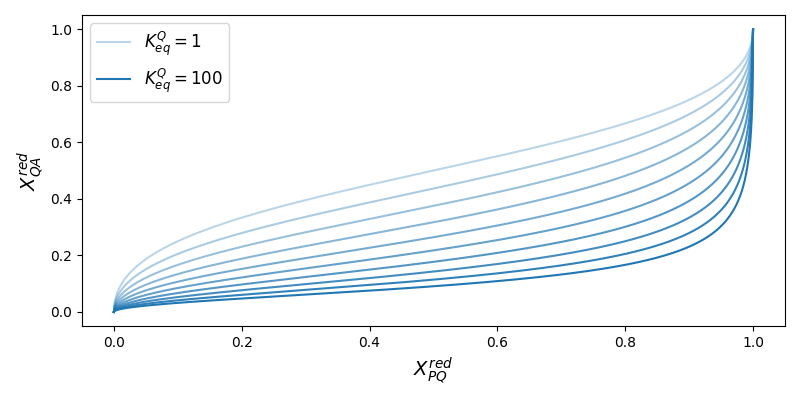

In [66]:
X_PQ_red = np.linspace(0, 1, 1000)

K_PSII = np.logspace(0, 2, 10)

fig, ax = plt.subplots(figsize=(8, 4))

alpha_values = np.linspace(0.3, 1, len(K_PSII))

def equation(X_QA_red, K, X_PQ_red):
    return K * (1 - X_PQ_red) * X_QA_red**2 - X_PQ_red * (1 - X_QA_red)**2

for i, K in zip(alpha_values, K_PSII):
    X_QA_red = np.zeros_like(X_PQ_red)
    for j, X_PQ in enumerate(X_PQ_red):
        sol = root(equation, 0.5, args=(K, X_PQ))
        X_QA_red[j] = sol.x[0]
    ax.plot(X_PQ_red, X_QA_red, color = "C0", alpha=i)

ax.plot([], [], color='C0', alpha = alpha_values[0], label= r"$K_{eq}^{Q} = $" + f"{K_PSII[0]:.0f}")
ax.plot([], [], color='C0', alpha = alpha_values[-1], label= r"$K_{eq}^{Q} = $" + f"{K_PSII[-1]:.0f}")

ax.set_xlabel(r'$X_{PQ}^{red}$', fontsize=14)
ax.set_ylabel(r'$X_{QA}^{red}$', fontsize=14)
ax.legend(fontsize=12)
fig.tight_layout()

fig.savefig(fig_folder + "PSII_equilibrium_solve.png", dpi=300)

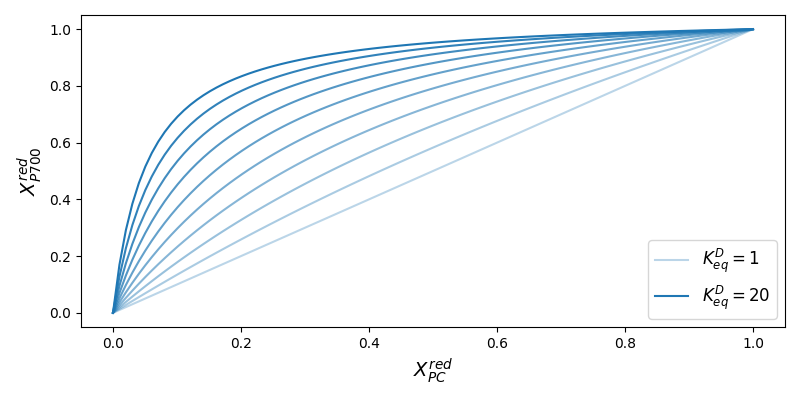

In [65]:
import numpy as np
import matplotlib.pyplot as plt

# Define the range for X_PC^red
X_PC_red = np.linspace(0, 1, 100)

# Define several values for K_eq^D
K_eq_D_values = np.logspace(0, np.log10(20), 10)

alpha_values = np.linspace(0.3, 1, len(K_eq_D_values))

# Create the plot
fig, ax = plt.subplots(figsize=(8, 4))

# Plot the equation for each value of K_eq^D
for i in range(len(K_eq_D_values)):
    ax.plot(X_PC_red, K_eq_D_values[i] * X_PC_red / (1 - X_PC_red + K_eq_D_values[i] * X_PC_red), color='C0', alpha=alpha_values[i])

ax.plot([], [], color='C0', alpha = alpha_values[0], label= r"$K_{eq}^{D} = $" + f"{K_eq_D_values[0]:.0f}")
ax.plot([], [], color='C0', alpha = alpha_values[-1], label= r"$K_{eq}^{D} = $" + f"{K_eq_D_values[-1]:.0f}")
    

# Add labels and legend
ax.set_xlabel(r'$X_{PC}^{red}$', fontsize=14)
ax.set_ylabel(r'$X_{P700}^{red}$', fontsize=14)
ax.legend(fontsize=12)

fig.tight_layout()

fig.savefig(fig_folder + "PSI_equilibrium_solve.png", dpi=300)

In [88]:
def model_pools(Y, t, fluxes, parameters):
    # Unpack the pools
    Y_Q_red = Y[0]
    Y_D_red = Y[1]
    
    # Unpack the fluxes
    J_PSII = fluxes[0]
    J_b6f = fluxes[1]
    J_PSI = fluxes[2]
    
    # Unpack the needed parameters
    PQ_tot = parameters["PQ_tot"]
    PC_tot = parameters["PC_tot"]
    QA_tot = parameters["QA_tot"]
    P700_tot = parameters["P700_tot"]
    
    # Calculate the defivative of the pools
    
    dY_Q_red = (J_PSII - J_b6f) / (2*PQ_tot + QA_tot)
    dY_D_red = (J_b6f - J_PSI) / (P700_tot + PC_tot)
    
    return [dY_Q_red, dY_D_red]

def get_concentrations(Y, parameters):
    from scipy.optimize import fsolve
    
    # Unpack the pools
    Y_Q_red = Y[0]
    Y_D_red = Y[1]
    
    # Thermodynamics of pool Q
    def concentrations_Q(X_Q, Y_Q_red, params):
        # Unpack pool Q concentrations
        X_QA_red = X_Q[0]
        X_PQ_red = X_Q[1]
        
        # Unpack the parameters needed
        K_Q = params["K_Q"]
        PQ_tot = params["PQ_tot"]
        QA_tot = params["QA_tot"]
    
        thermo_Q =  K_Q * (1 - X_PQ_red) * X_QA_red**2 - X_PQ_red * (1 - X_QA_red)**2
        partition_Q = Y_Q_red * (2*PQ_tot + QA_tot) - 2*PQ_tot * X_PQ_red - QA_tot * (X_QA_red)
        
        return [thermo_Q, partition_Q]
    
    solution_Q = fsolve(concentrations_Q, [0.5, 0.5], args=(Y_Q_red, parameters))
    X_QA_red = solution_Q[0]
    X_PQ_red = solution_Q[1]
    
    # Thermodynamics of pool D
    def concentrations_D(X_D, Y_D_red, params):
        # Unpack pool D concentrations
        X_PC_red = X_D[0]
        X_P700_red = X_D[1]
        
        # Unpack the parameters needed
        K_D = params["K_D"]
        PC_tot = params["PC_tot"]
        P700_tot = params["P700_tot"]
    
        thermo_D = K_D * X_PC_red * (1 - X_P700_red) - X_P700_red * (1 - X_PC_red)
        partition_D = Y_D_red * (P700_tot + PC_tot) - P700_tot * X_P700_red - PC_tot * X_PC_red
        
        return [thermo_D, partition_D]
    
    solution_D = fsolve(concentrations_D, [0.5, 0.5], args=(Y_D_red, parameters))
    X_PC_red = solution_D[0]
    X_P700_red = solution_D[1]
    

    return [X_QA_red, X_PQ_red, X_PC_red, X_P700_red]

def get_fluxes(Y, I, parameters):
    # Unpack the parameters needed
    sigma_PSII = parameters["sigma_PSII"]
    sigma_PSI = parameters["sigma_PSI"]
    k_p = parameters["k_p"]
    k_fh = parameters["k_fh"]
    k_b6f = parameters["k_b6f"]
    QA_tot = parameters["QA_tot"]
    PQ_tot = parameters["PQ_tot"]
    PC_tot = parameters["PC_tot"]
    P700_tot = parameters["P700_tot"]
    
    # get the degrees of reduction
    concentrations = get_concentrations(Y, parameters)
    
    X_QA_red = concentrations[0]
    X_PQ_red = concentrations[1]
    X_PC_red = concentrations[2]
    X_P700_red = concentrations[3]
    
    # Calculate concentrations from degrees of reduction
    C_QA = QA_tot * X_QA_red
    C_PQH2 = PQ_tot * (1 - X_PQ_red)
    C_PC_plus = PC_tot * (1 - X_PC_red)
    C_P700 = P700_tot * (1 - X_P700_red)
    
    # Calculate the fluxes
    J_PSII = (I * sigma_PSII * k_p * C_QA) / (k_p * C_QA + k_fh)
    J_b6f = k_b6f * C_PC_plus * C_PQH2
    J_PSI = (I * sigma_PSI * C_P700) / (P700_tot)
    
    return [J_PSII, J_b6f, J_PSI]





    

In [118]:
### define model parameters ###

sigma_PSII = 1
sigma_PSI = 1
k_p = 1
k_fh = 3.5
k_b6f = 10
k_PSI = 1
QA_tot = 1
PQ_tot = 7
PC_tot = 5
P700_tot = 2
K_Q = 50
K_D = 20

parameter_keys = ["sigma_PSII", "sigma_PSI", "k_p", "k_fh", "k_b6f", "k_PSI", "QA_tot", "PQ_tot", "PC_tot", "P700_tot", "K_Q", "K_D"]
parameters = dict(zip(parameter_keys, [sigma_PSII, sigma_PSI, k_p, k_fh, k_b6f, k_PSI, QA_tot, PQ_tot, PC_tot, P700_tot, K_Q, K_D]))

In [119]:
Y_Q_red = np.linspace(0, 1, 100)
Y_D_red = np.linspace(0, 1, 100)

X_QA_red = np.zeros(len(Y_Q_red))
X_PQ_red = np.zeros(len(Y_Q_red))
X_PC_red = np.zeros(len(Y_D_red))
X_P700_red = np.zeros(len(Y_D_red))

for i in range(len(Y_Q_red)):
    for j in range(len(Y_D_red)):
        Y = [Y_Q_red[i], Y_D_red[j]]
        X_QA_red[i], X_PQ_red[i], X_PC_red[j], X_P700_red[j] = get_concentrations(Y, parameters)
        

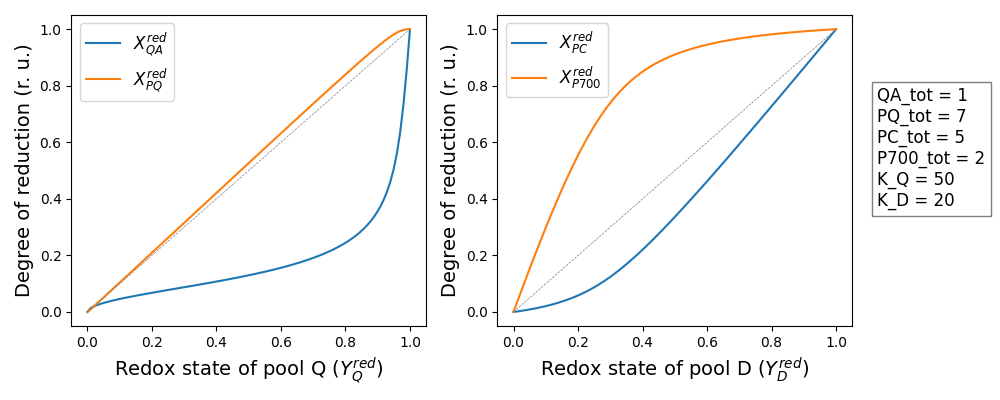

In [127]:
fig, ax = plt.subplots(1,2, figsize=(10, 4))

ax[0].plot(Y_Q_red, X_QA_red, label=r"$X_{QA}^{red}$")
ax[0].plot(Y_Q_red, X_PQ_red, label=r"$X_{PQ}^{red}$")

ax[1].plot(Y_D_red, X_PC_red, label=r"$X_{PC}^{red}$")
ax[1].plot(Y_D_red, X_P700_red, label=r"$X_{P700}^{red}$")

ax[0].set_xlabel(r"Redox state of pool Q ($Y_{Q}^{red}$)", fontsize=14)
ax[0].set_ylabel("Degree of reduction (r. u.)", fontsize=14)

ax[1].set_xlabel(r"Redox state of pool D ($Y_{D}^{red}$)", fontsize=14)
ax[1].set_ylabel("Degree of reduction (r. u.)", fontsize=14)

ax[0].plot([0, 1], [0, 1], 'gray', linestyle='--', linewidth=0.5)
ax[1].plot([0, 1], [0, 1], 'gray', linestyle='--', linewidth=0.5)

ax[0].legend(fontsize=12)
ax[1].legend(fontsize=12)

parameters_to_show = ["QA_tot", "PQ_tot", "PC_tot", "P700_tot", "K_Q", "K_D"]
parameters_str = "\n".join([f"{key} = {parameters[key]}" for key in parameters_to_show])
ax[1].text(1.07, 0.57, parameters_str, fontsize=12, verticalalignment='center', transform=ax[1].transAxes, bbox=dict(facecolor='white', alpha=0.5))

fig.tight_layout()

fig.savefig(fig_folder + "Pools_concentrations.png", dpi=300)


In [10]:
def model(y, t, I, parameters):
    # Unpack state variables (degree of reduction)
    X_PQ_red = y[0]
    X_PC_red = y[1]
    
    # Unpack parameters
    sigma_PSII = parameters["sigma_PSII"]
    sigma_PSI = parameters["sigma_PSI"]
    k_p = parameters["k_p"]
    k_fh = parameters["k_fh"]
    k_b6f = parameters["k_b6f"]
    k_PSI = parameters["k_PSI"]
    PQ_tot = parameters["PQ_tot"]
    PC_tot = parameters["PC_tot"]
    
    # Calculate concentrations from degrees of reduction
    C_PQ = PQ_tot * (1 - X_PQ_red)
    C_PQH2 = PQ_tot * X_PQ_red
    C_PC_plus = PC_tot * (1 - X_PC_red)
    C_PC = PC_tot * X_PC_red
    
    # Calculate fluxes using concentrations
    J_PSII = (I * sigma_PSII * k_p * C_PQ) / (k_p * C_PQ + k_fh)
    J_b6f = k_b6f * C_PC_plus * C_PQH2
    J_PSI = k_PSI * I * sigma_PSI * C_PC
    
    # Calculate derivatives of the degree of reduction
    dX_PQ_red_dt = (J_PSII - J_b6f) / PQ_tot
    dX_PC_red_dt = (2 * J_b6f - J_PSI) / PC_tot
    
    return [dX_PQ_red_dt, dX_PC_red_dt]

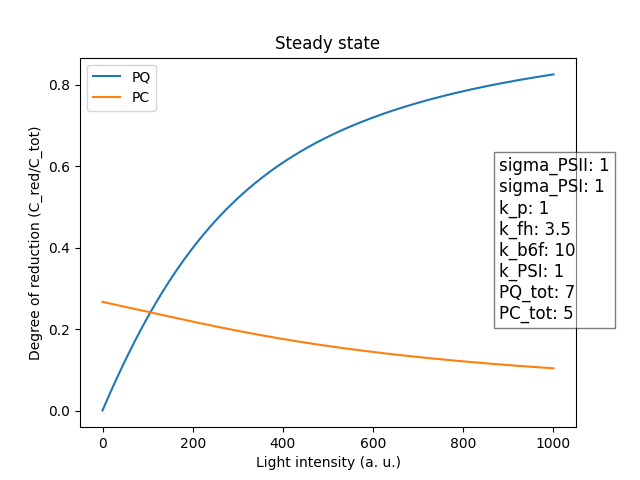

In [11]:
####### steady state light curve #######

def light_curve(min_light, max_light, light_steps, parameters):
    light_range = np.linspace(min_light, max_light, light_steps)[::-1]

    X_PQ_red_steady = np.zeros(light_steps)
    X_PC_red_steady = np.zeros(light_steps)

    ### initial guess for the max light ###
    X_PQ_red_guess = 1
    X_PC_red_guess = 0

    for i, light in enumerate(light_range):
        if i == 0:
            y0 = [X_PQ_red_guess, X_PC_red_guess]
        else:
            y0 = [X_PQ_red_steady[i-1], X_PC_red_steady[i-1]]

        sol = root(model, y0, args=(0, light, parameters))
        X_PQ_red_steady[i] = sol.x[0]
        X_PC_red_steady[i] = sol.x[1]

    return light_range, X_PQ_red_steady, X_PC_red_steady

### define model parameters ###

sigma_PSII = 1
sigma_PSI = 1
k_p = 1
k_fh = 3.5
k_b6f = 10
k_PSI = 1
PQ_tot = 7
PC_tot = 5

parameter_keys = ['sigma_PSII', 'sigma_PSI', 'k_p', 'k_fh', 'k_b6f', 'k_PSI', 'PQ_tot', 'PC_tot']
parameters = dict(zip(parameter_keys, [sigma_PSII, sigma_PSI, k_p, k_fh, k_b6f, k_PSI, PQ_tot, PC_tot]))

### define light curve parameters ###

min_light = 0.1
max_light = 1000
light_steps = 1000


### run the model ###
light_range, X_PQ_red_steady, X_PC_red_steady = light_curve(min_light, max_light, light_steps, parameters)

### plot the results ###
    
fig, ax = plt.subplots()
ax.set_title('Steady state')
ax.plot(light_range, X_PQ_red_steady, label='PQ')
ax.plot(light_range, X_PC_red_steady, label='PC')
ax.set_ylabel('Degree of reduction (C_red/C_tot)')
ax.set_xlabel('Light intensity (a. u.)')
ax.legend()

# Create a string with parameter names and values
parameters_str = '\n'.join([f'{key}: {value}' for key, value in parameters.items()])

# Add the text box to the right of the plot but within the figure
plt.gcf().text(0.78, 0.5, parameters_str, fontsize=12, verticalalignment='center', bbox=dict(facecolor='white', alpha=0.5))
plt.show()

fig.tight_layout()


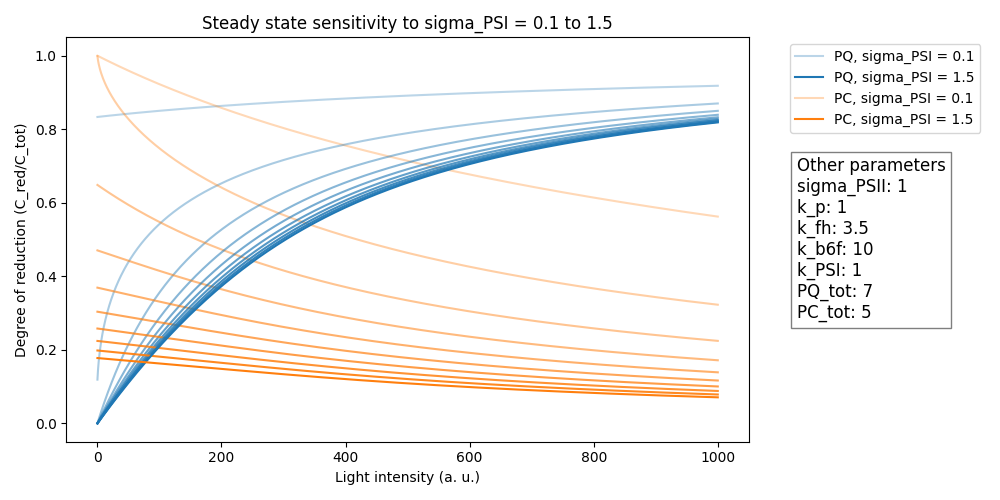

In [12]:
####### Parameter sensitivity of steady state solution #######

####### define all parameters ######

sigma_PSII = 1
sigma_PSI = 1
k_p = 1
k_fh = 3.5
k_b6f = 10
k_PSI = 1
PQ_tot = 7
PC_tot = 5

parameter_keys = ['sigma_PSII', 'sigma_PSI', 'k_p', 'k_fh', 'k_b6f', 'k_PSI', 'PQ_tot', 'PC_tot']
parameters = dict(zip(parameter_keys, [sigma_PSII, sigma_PSI, k_p, k_fh, k_b6f, k_PSI, PQ_tot, PC_tot]))

# Define the parameter to vary and the range of values
parameter_to_vary = 'sigma_PSI'
min_value = 0.1
max_value = 1.5
n_values = 10
parameter_values = np.linspace(min_value, max_value, n_values)

# Parameters for the light curve
min_light = 0.1
max_light = 1000
light_steps = 1000

# Create a dictionary to store the results
X_PQ_red_steady_values = np.zeros((n_values, light_steps))
X_PC_red_steady_values = np.zeros((n_values, light_steps))

# Run the light curve for each parameter value

for i, value in enumerate(parameter_values):
    parameters[parameter_to_vary] = value
    light_range, X_PQ_red_steady_values[i], X_PC_red_steady_values[i] = light_curve(min_light, max_light, light_steps, parameters)

# Plot the results
fig, ax = plt.subplots(figsize=(10, 5))
ax.set_title(f"Steady state sensitivity to {parameter_to_vary} = {min_value} to {max_value}")
alpha_values = np.linspace(0.3, 1, n_values)
for i, value in enumerate(parameter_values):
    ax.plot(light_range, X_PQ_red_steady_values[i], color = "C0", alpha = alpha_values[i])
    ax.plot(light_range, X_PC_red_steady_values[i], color = "C1", alpha = alpha_values[i])

ax.plot([], [], color = "C0", alpha = alpha_values[0], label = f"PQ, {parameter_to_vary} = {parameter_values[0]}")
ax.plot([], [], color = "C0", alpha = alpha_values[-1], label = f"PQ, {parameter_to_vary} = {parameter_values[-1]}")
ax.plot([], [], color = "C1", alpha = alpha_values[0], label = f"PC, {parameter_to_vary} = {parameter_values[0]}")
ax.plot([], [], color = "C1", alpha = alpha_values[-1], label = f"PC, {parameter_to_vary} = {parameter_values[-1]}")

ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Create a string with parameter names and values
parameters_str = 'Other parameters'
for key in parameters.keys():
    if key == parameter_to_vary:
        continue
    parameters_str += f'\n{key}: {parameters[key]}'
    
ax.text(1.07, 0.5, parameters_str, fontsize=12, verticalalignment='center', transform=ax.transAxes, bbox=dict(facecolor='white', alpha=0.5))


ax.set_ylabel('Degree of reduction (C_red/C_tot)')
ax.set_xlabel('Light intensity (a. u.)')

fig.tight_layout()

fig.savefig(fig_folder + f"sensitivity_steady_state_{parameter_to_vary}.png", dpi=300)

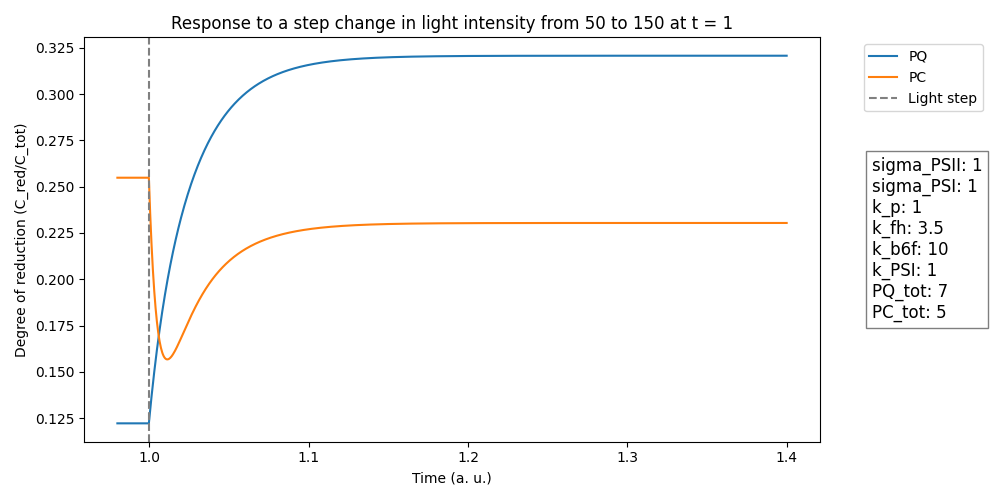

In [13]:
######## Dynamic response to a step change in light intensity ########

def response_step(light_1, light_2, time_light, t_start, t_end, n_points, parameters):
    time = np.linspace(t_start, t_end, n_points)
    light = np.zeros(n_points)
    light[time < time_light] = light_1
    light[time >= time_light] = light_2

    X_PQ_red = np.zeros(n_points)
    X_PC_red = np.zeros(n_points)
    
    ### compute the initial conditions from steady state at light 1 ###
    steady_state_sol = root(model, [0.5, 0.5], args=(0, light_1, parameters))

    X_PQ_red[0] = steady_state_sol.x[0]
    X_PC_red[0] = steady_state_sol.x[1]
    
    ### integrate the model one time step at a time ###

    for i in range(1, n_points):
        time_interval = [time[i-1], time[i]]
        y = odeint(model, [X_PQ_red[i-1], X_PC_red[i-1]], time_interval, args=(light[i], parameters))
        X_PQ_red[i] = y[-1, 0]
        X_PC_red[i] = y[-1, 1]
        
    return time, light, X_PQ_red, X_PC_red


### define model parameters ###

sigma_PSII = 1
sigma_PSI = 1
k_p = 1
k_fh = 3.5
k_b6f = 10
k_PSI = 1
PQ_tot = 7
PC_tot = 5

parameter_keys = ['sigma_PSII', 'sigma_PSI', 'k_p', 'k_fh', 'k_b6f', 'k_PSI', 'PQ_tot', 'PC_tot']
parameters = dict(zip(parameter_keys, [sigma_PSII, sigma_PSI, k_p, k_fh, k_b6f, k_PSI, PQ_tot, PC_tot]))

### define the time points for the simulation ###
t_start = 0.98
t_end = 1.4
n_points = 1000

### define the actinic light ###
light_1 = 50
light_2 = 150
time_light = 1

### run the model ###

time, light, X_PQ_red, X_PC_red = response_step(light_1, light_2, time_light, t_start, t_end, n_points, parameters)
    
### plot the results ###
fig, ax = plt.subplots(figsize=(10, 5))
ax.set_title(f"Response to a step change in light intensity from {light_1} to {light_2} at t = {time_light}")
ax.plot(time, X_PQ_red, label='PQ')
ax.plot(time, X_PC_red, label='PC')
ax.axvline(time_light, color='gray', linestyle='--', label='Light step')

ax.set_ylabel('Degree of reduction (C_red/C_tot)')
ax.set_xlabel('Time (a. u.)')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

parameters_str = '\n'.join([f'{key}: {value}' for key, value in parameters.items()])
ax.text(1.07, 0.5, parameters_str, fontsize=12, verticalalignment='center', transform=ax.transAxes, bbox=dict(facecolor='white', alpha=0.5))


fig.tight_layout()    


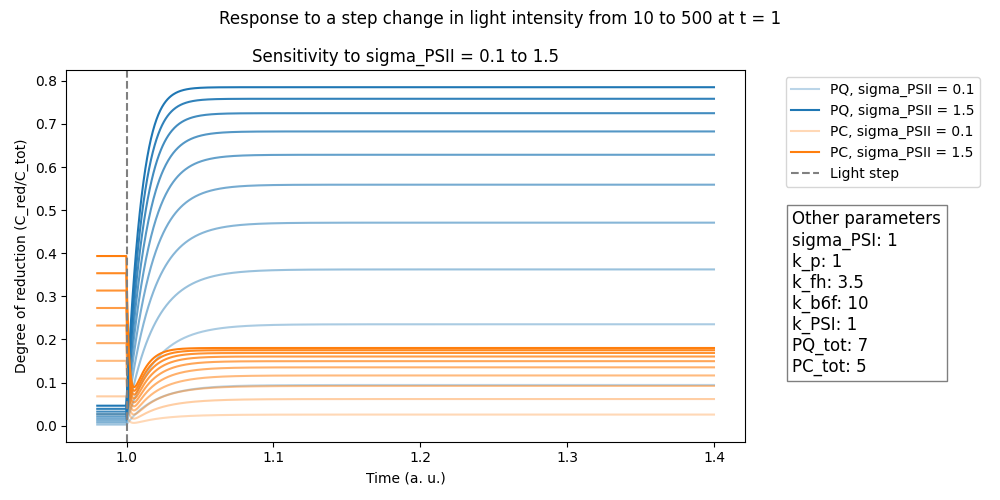

In [14]:
#### Parameter sensitivity of dynamic response to a step change in light intensity ####

# define all parameters 

sigma_PSII = 1
sigma_PSI = 1
k_p = 1
k_fh = 3.5
k_b6f = 10
k_PSI = 1
PQ_tot = 7
PC_tot = 5

parameter_keys = ['sigma_PSII', 'sigma_PSI', 'k_p', 'k_fh', 'k_b6f', 'k_PSI', 'PQ_tot', 'PC_tot']
parameters = dict(zip(parameter_keys, [sigma_PSII, sigma_PSI, k_p, k_fh, k_b6f, k_PSI, PQ_tot, PC_tot]))

# Define the parameter to vary and the range of values
parameter_to_vary = 'sigma_PSII'
min_value = 0.1
max_value = 1.5
n_values = 10
parameter_values = np.linspace(min_value, max_value, n_values)

# Parameters for the time points
t_start = 0.98
t_end = 1.4
n_points = 1000

# Define the actinic light step
light_1 = 10
light_2 = 500
time_light = 1

# Create a dictionary to store the results
X_PQ_red = np.zeros((n_values, n_points))
X_PC_red = np.zeros((n_values, n_points))

# Run the dynamic response for each parameter value
for i, value in enumerate(parameter_values):
    parameters[parameter_to_vary] = value
    time, light, X_PQ_red[i], X_PC_red[i] = response_step(light_1, light_2, time_light, t_start, t_end, n_points, parameters)

# Plot the results
fig, ax = plt.subplots(figsize=(10, 5))
fig.suptitle(f"Response to a step change in light intensity from {light_1} to {light_2} at t = {time_light}")
ax.set_title(f"Sensitivity to {parameter_to_vary} = {min_value} to {max_value}")
alpha_values = np.linspace(0.3, 1, n_values)
for i, value in enumerate(parameter_values):
    ax.plot(time, X_PQ_red[i], color = "C0", alpha = alpha_values[i])
    ax.plot(time, X_PC_red[i], color = "C1", alpha = alpha_values[i])
    
ax.plot([], [], color = "C0", alpha = alpha_values[0], label = f"PQ, {parameter_to_vary} = {parameter_values[0]}")
ax.plot([], [], color = "C0", alpha = alpha_values[-1], label = f"PQ, {parameter_to_vary} = {parameter_values[-1]}")
ax.plot([], [], color = "C1", alpha = alpha_values[0], label = f"PC, {parameter_to_vary} = {parameter_values[0]}")
ax.plot([], [], color = "C1", alpha = alpha_values[-1], label = f"PC, {parameter_to_vary} = {parameter_values[-1]}")
ax.axvline(time_light, color='gray', linestyle='--', label='Light step')
ax.set(xlabel='Time (a. u.)', ylabel='Degree of reduction (C_red/C_tot)')

ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Create a string with parameter names and values
parameters_str = 'Other parameters'
for key in parameters.keys():
    if key == parameter_to_vary:
        continue
    parameters_str += f'\n{key}: {parameters[key]}'

ax.text(1.07, 0.4, parameters_str, fontsize=12, verticalalignment='center', transform=ax.transAxes, bbox=dict(facecolor='white', alpha=0.5))

fig.tight_layout()

fig.savefig(fig_folder + f"sensitivity_step_response_{parameter_to_vary}.png", dpi=300)


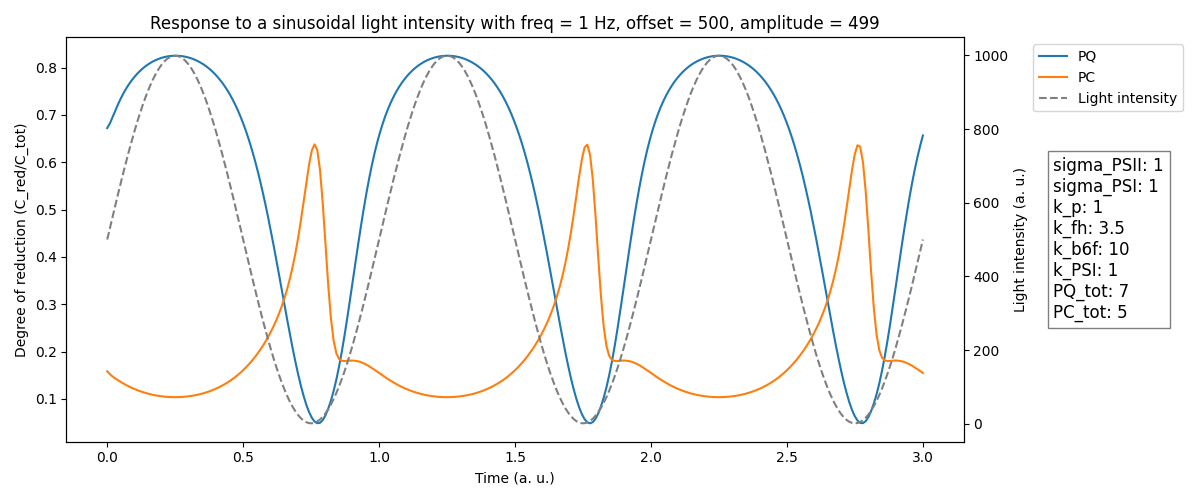

In [15]:
####### Dynamic response to a sinusoidal light intensity #######


def response_sinusoid(freq, nb_periods, points_per_period, offset, amplitude, parameters):
    time = np.linspace(0, nb_periods/freq, nb_periods * points_per_period)
    light = offset + amplitude * np.sin(2 * np.pi * freq * time)

    X_PQ_red = np.zeros(nb_periods * points_per_period)
    X_PC_red = np.zeros(nb_periods * points_per_period)
    
    ### compute the initial conditions from steady state at light 1 ###
    steady_state_sol = root(model, [0.5, 0.5], args=(0, offset, parameters))

    X_PQ_red[0] = steady_state_sol.x[0]
    X_PC_red[0] = steady_state_sol.x[1]
    
    ### integrate the model one time step at a time ###

    for i in range(1, nb_periods * points_per_period):
        time_interval = [time[i-1], time[i]]
        y = odeint(model, [X_PQ_red[i-1], X_PC_red[i-1]], time_interval, args=(light[i], parameters))
        X_PQ_red[i] = y[-1, 0]
        X_PC_red[i] = y[-1, 1]
        
    return time, light, X_PQ_red, X_PC_red

# define model parameters

sigma_PSII = 1
sigma_PSI = 1
k_p = 1
k_fh = 3.5
k_b6f = 10
k_PSI = 1
PQ_tot = 7
PC_tot = 5

parameter_keys = ['sigma_PSII', 'sigma_PSI', 'k_p', 'k_fh', 'k_b6f', 'k_PSI', 'PQ_tot', 'PC_tot']
parameters = dict(zip(parameter_keys, [sigma_PSII, sigma_PSI, k_p, k_fh, k_b6f, k_PSI, PQ_tot, PC_tot]))


freq = 1 #Hz

# Define acquisition parameters 

nb_periods = 3
points_per_period = 100

# Define the light intensity

offset = 500
amplitude = 499

# Run the model

time, light, X_PQ_red, X_PC_red = response_sinusoid(freq, nb_periods, points_per_period, offset, amplitude, parameters)

# Plot the results

fig, ax = plt.subplots(figsize=(12, 5))
ax.set_title(f"Response to a sinusoidal light intensity with freq = {freq} Hz, offset = {offset}, amplitude = {amplitude}")
ax.plot(time, X_PQ_red, label='PQ')
ax.plot(time, X_PC_red, label='PC')
ax2 = ax.twinx()
ax2.plot(time, light, color='gray', linestyle='--')
ax.plot([], [], color='gray', linestyle='--', label='Light intensity')
ax.set_ylabel('Degree of reduction (C_red/C_tot)')
ax.set_xlabel('Time (a. u.)')
ax2.set_ylabel('Light intensity (a. u.)')
ax.legend(bbox_to_anchor=(1.07, 1), loc='upper left')
fig.tight_layout()

# Create a string with parameter names and values
parameters_str = '\n'.join([f'{key}: {value}' for key, value in parameters.items()])
ax.text(1.1, 0.5, parameters_str, fontsize=12, verticalalignment='center', transform=ax.transAxes, bbox=dict(facecolor='white', alpha=0.5))

fig.savefig(fig_folder + f"sinusoidal_light_f_{freq}_Hz_amp_{amplitude}_offset_{offset}.png", dpi=300)


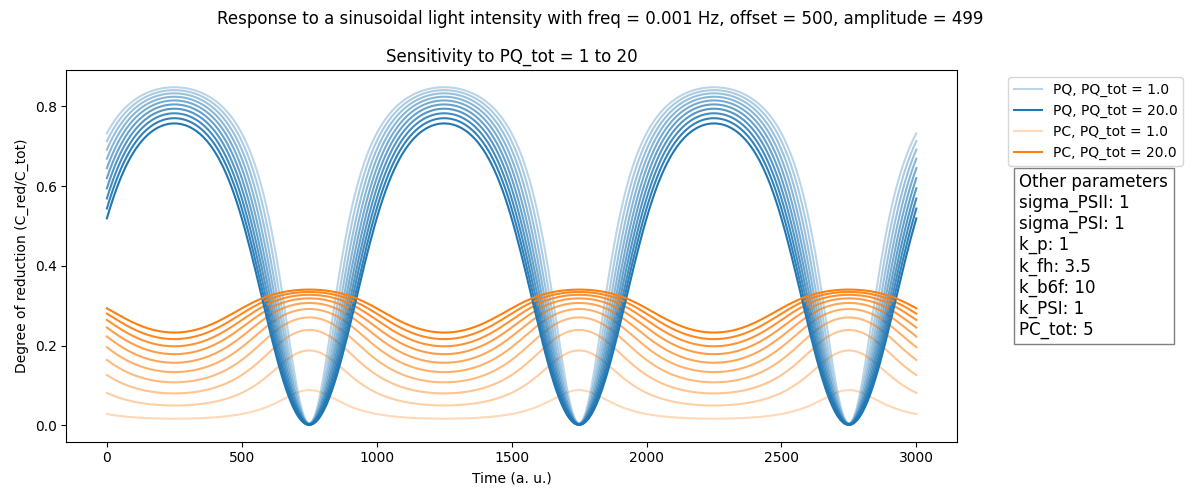

In [16]:
####### Parameter sensitivity of dynamic response to a sinusoidal light intensity #######

# define all parameters

sigma_PSII = 1
sigma_PSI = 1
k_p = 1
k_fh = 3.5
k_b6f = 10
k_PSI = 1
PQ_tot = 7
PC_tot = 5


parameter_keys = ['sigma_PSII', 'sigma_PSI', 'k_p', 'k_fh', 'k_b6f', 'k_PSI', 'PQ_tot', 'PC_tot']
parameters = dict(zip(parameter_keys, [sigma_PSII, sigma_PSI, k_p, k_fh, k_b6f, k_PSI, PQ_tot, PC_tot]))

# Define the parameter to vary and the range of values
parameter_to_vary = 'PQ_tot'
min_value = 1
max_value = 20
n_values = 10
parameter_values = np.linspace(min_value, max_value, n_values)

# Parameters for the sinusoidal light
freq = 0.001
nb_periods = 3
points_per_period = 100
offset = 500
amplitude = 499

# Create a dictionary to store the results
X_PQ_red = np.zeros((n_values, nb_periods * points_per_period))
X_PC_red = np.zeros((n_values, nb_periods * points_per_period))

# Run the dynamic response for each parameter value
for i, value in enumerate(parameter_values):
    parameters[parameter_to_vary] = value
    time, light, X_PQ_red[i], X_PC_red[i] = response_sinusoid(freq, nb_periods, points_per_period, offset, amplitude, parameters)
    
# Plot the results
fig, ax = plt.subplots(figsize=(12, 5))
fig.suptitle(f"Response to a sinusoidal light intensity with freq = {freq} Hz, offset = {offset}, amplitude = {amplitude}")
ax.set_title(f"Sensitivity to {parameter_to_vary} = {min_value} to {max_value}")
alpha_values = np.linspace(0.3, 1, n_values)
for i, value in enumerate(parameter_values):
    ax.plot(time, X_PQ_red[i], color = "C0", alpha = alpha_values[i])
    ax.plot(time, X_PC_red[i], color = "C1", alpha = alpha_values[i])

ax.plot([], [], color = "C0", alpha = alpha_values[0], label = f"PQ, {parameter_to_vary} = {parameter_values[0]}")
ax.plot([], [], color = "C0", alpha = alpha_values[-1], label = f"PQ, {parameter_to_vary} = {parameter_values[-1]}")
ax.plot([], [], color = "C1", alpha = alpha_values[0], label = f"PC, {parameter_to_vary} = {parameter_values[0]}")
ax.plot([], [], color = "C1", alpha = alpha_values[-1], label = f"PC, {parameter_to_vary} = {parameter_values[-1]}")
ax.set(xlabel='Time (a. u.)', ylabel='Degree of reduction (C_red/C_tot)')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Create a string with parameter names and values
parameters_str = 'Other parameters'
for key in parameters.keys():
    if key == parameter_to_vary:
        continue
    parameters_str += f'\n{key}: {parameters[key]}'
    
ax.text(1.07, 0.5, parameters_str, fontsize=12, verticalalignment='center', transform=ax.transAxes, bbox=dict(facecolor='white', alpha=0.5))

fig.tight_layout()

fig.savefig(fig_folder + f"sensitivity_sinusoidal_{parameter_to_vary}.png", dpi=300)


In [81]:
####### Bode plot of the dynamic response to a sinusoidal light intensity #######

from tqdm.notebook import tqdm

def get_harmonics(input_freq, F, A, P, pic_search_window):
    index_fund = tools.closest_index(F, input_freq)
    harmonics = {'f_input': input_freq}
    for i in range(5):
        index = index_fund*(i+1)
        search_window = [index - pic_search_window, index + pic_search_window]
        index_max = np.argmax(A[search_window[0]:search_window[1]]) + search_window[0]
        harmonics[f'A_{i}'] = A[index_max]
        harmonics[f'f_{i}'] = F[index_max]
        harmonics[f'P_{i}'] = P[index_max]

    return pd.DataFrame(harmonics, index=[0])

def simulate_bode_plot(freq_min, freq_max, nb_freqs, nb_periods, points_per_period, period_start_fft, offset, amplitude, parameters):
    
    # Create a dictionary to store the results
    X_PQ_red = np.zeros((nb_freqs, nb_periods * points_per_period))
    X_PC_red = np.zeros((nb_freqs, nb_periods * points_per_period))
    times = np.zeros((nb_freqs, nb_periods * points_per_period))

    # Run the dynamic response for each frequency
    frequencies = np.logspace(np.log10(freq_min), np.log10(freq_max), nb_freqs)

    harmonics_PQ = pd.DataFrame()
    harmonics_PC = pd.DataFrame()

    for i in tqdm(range(nb_freqs), desc='Frequency scan'):
        freq = frequencies[i]
        times[i], _, X_PQ_red[i], X_PC_red[i] = response_sinusoid(freq, nb_periods, points_per_period, offset, amplitude, parameters)
        F, A, P = tools.FFT(times[i][int(points_per_period*period_start_fft):], X_PQ_red[i][int(points_per_period*period_start_fft):])
        harmonics_PQ = pd.concat([harmonics_PQ, get_harmonics(freq, F, A, P, 5)])
        
        F, A, P = tools.FFT(times[i][int(points_per_period*period_start_fft):], X_PC_red[i][int(points_per_period*period_start_fft):])
        harmonics_PC = pd.concat([harmonics_PC, get_harmonics(freq, F, A, P, 5)])

    return harmonics_PQ, harmonics_PC, frequencies, times, X_PQ_red, X_PC_red 

# define the acquisition parameters

freq_min = 0.01
freq_max = 1000
nb_freqs = 20

nb_periods = 20
points_per_period = 100
period_start_fft = 10

# define the light intensity

offset = 100
amplitude = 50

# define model parameters

sigma_PSII = 1
sigma_PSI = 1
k_p = 1
k_fh = 3.5
k_b6f = 10
k_PSI = 1
PQ_tot = 7
PC_tot = 5

parameter_keys = ['sigma_PSII', 'sigma_PSI', 'k_p', 'k_fh', 'k_b6f', 'k_PSI', 'PQ_tot', 'PC_tot']
parameters = dict(zip(parameter_keys, [sigma_PSII, sigma_PSI, k_p, k_fh, k_b6f, k_PSI, PQ_tot, PC_tot]))

# run the model

harmonics_PQ, harmonics_PC, frequencies, times, X_PQ_red, X_PC_red = simulate_bode_plot(freq_min, freq_max, nb_freqs, nb_periods, points_per_period, period_start_fft, offset, amplitude, parameters)



Frequency scan:   0%|          | 0/20 [00:00<?, ?it/s]

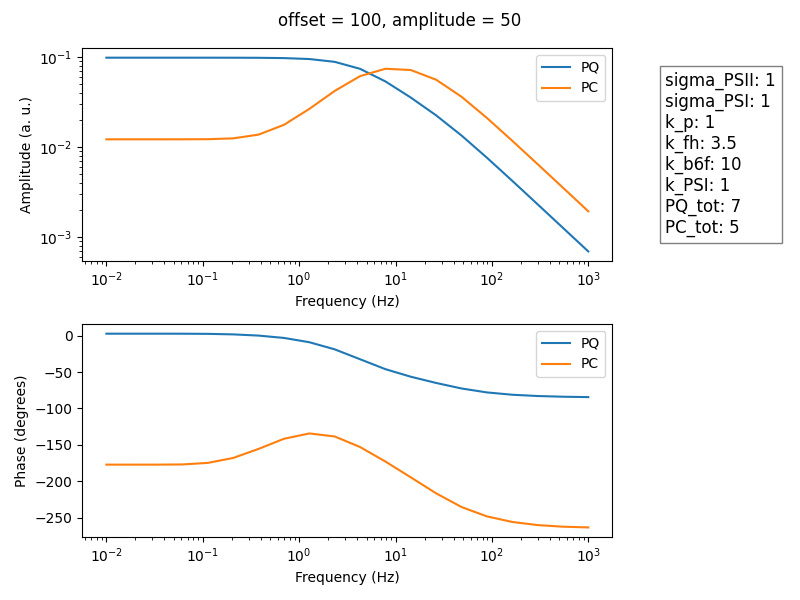

In [82]:
# Plot the results

fig, ax = plt.subplots(2, 1, figsize=(8, 6))
fig.suptitle(f"offset = {offset}, amplitude = {amplitude}")
ax[0].loglog(frequencies, harmonics_PQ['A_0'], label='PQ')
ax[0].loglog(frequencies, harmonics_PC['A_0'], label='PC')
ax[0].set_ylabel('Amplitude (a. u.)')
ax[0].set_xlabel('Frequency (Hz)')
ax[0].legend()
ax[1].semilogx(frequencies, harmonics_PQ['P_0'] + 90 , label='PQ')
ax[1].semilogx(frequencies, harmonics_PC['P_0'] + 90 - 360, label='PC')
ax[1].set_xlabel('Frequency (Hz)')
ax[1].set_ylabel('Phase (degrees)')
ax[1].legend()

# Create a string with parameter names and values
parameters_str = '\n'.join([f'{key}: {value}' for key, value in parameters.items()])
ax[0].text(1.1, 0.5, parameters_str, fontsize=12, verticalalignment='center', transform=ax[0].transAxes, bbox=dict(facecolor='white', alpha=0.5))

fig.tight_layout()


In [97]:
results

[concurrent.futures.process.BrokenProcessPool('A process in the process pool was terminated abruptly while the future was running or pending.'),
 concurrent.futures.process.BrokenProcessPool('A process in the process pool was terminated abruptly while the future was running or pending.'),
 concurrent.futures.process.BrokenProcessPool('A process in the process pool was terminated abruptly while the future was running or pending.'),
 concurrent.futures.process.BrokenProcessPool('A process in the process pool was terminated abruptly while the future was running or pending.'),
 concurrent.futures.process.BrokenProcessPool('A process in the process pool was terminated abruptly while the future was running or pending.'),
 concurrent.futures.process.BrokenProcessPool('A process in the process pool was terminated abruptly while the future was running or pending.'),
 concurrent.futures.process.BrokenProcessPool('A process in the process pool was terminated abruptly while the future was running 

In [ ]:
###### Parameter sensitivity of the Bode plot ######

from tqdm.notebook import tqdm

# define all parameters

sigma_PSII = 1
sigma_PSI = 1
k_p = 1
k_fh = 3.5
k_b6f = 30
k_PSI = 1
PQ_tot = 20
PC_tot = 2


parameter_keys = ['sigma_PSII', 'sigma_PSI', 'k_p', 'k_fh', 'k_b6f', 'k_PSI', 'PQ_tot', 'PC_tot']
parameters = dict(zip(parameter_keys, [sigma_PSII, sigma_PSI, k_p, k_fh, k_b6f, k_PSI, PQ_tot, PC_tot]))

# Define the parameter to vary and the range of values
parameter_to_vary = 'PQ_tot'
min_value = 1
max_value = 50
n_values = 10
parameter_values = np.linspace(min_value, max_value, n_values)

# Parameters for the Bode plot
freq_min = 0.01
freq_max = 1000
nb_freqs = 50
nb_periods = 20
points_per_period = 100
period_start_fft = 10 
offset = 100
amplitude = 99

# Create a dictionary to store the results
harmonics_PQ_values = []
harmonics_PC_values = []
X_PC_red_values = []
X_PQ_red_values = []

# Run the Bode plot for each parameter value
for i in tqdm(range(n_values), desc='Parameter sensitivity'):
    parameters[parameter_to_vary] = parameter_values[i]
    harmonics_PQ, harmonics_PC, frequencies, times, X_PQ_red, X_PC_red = simulate_bode_plot(freq_min, freq_max, nb_freqs, nb_periods, points_per_period, period_start_fft, offset, amplitude, parameters)
    harmonics_PQ_values.append(harmonics_PQ)
    harmonics_PC_values.append(harmonics_PC)
    X_PQ_red_values.append(X_PQ_red)
    X_PC_red_values.append(X_PC_red)



Parameter sensitivity:   0%|          | 0/10 [00:00<?, ?it/s]

Frequency scan:   0%|          | 0/50 [00:00<?, ?it/s]

Frequency scan:   0%|          | 0/50 [00:00<?, ?it/s]

Frequency scan:   0%|          | 0/50 [00:00<?, ?it/s]

Frequency scan:   0%|          | 0/50 [00:00<?, ?it/s]

Frequency scan:   0%|          | 0/50 [00:00<?, ?it/s]

Frequency scan:   0%|          | 0/50 [00:00<?, ?it/s]

Frequency scan:   0%|          | 0/50 [00:00<?, ?it/s]

Frequency scan:   0%|          | 0/50 [00:00<?, ?it/s]

Frequency scan:   0%|          | 0/50 [00:00<?, ?it/s]

Frequency scan:   0%|          | 0/50 [00:00<?, ?it/s]

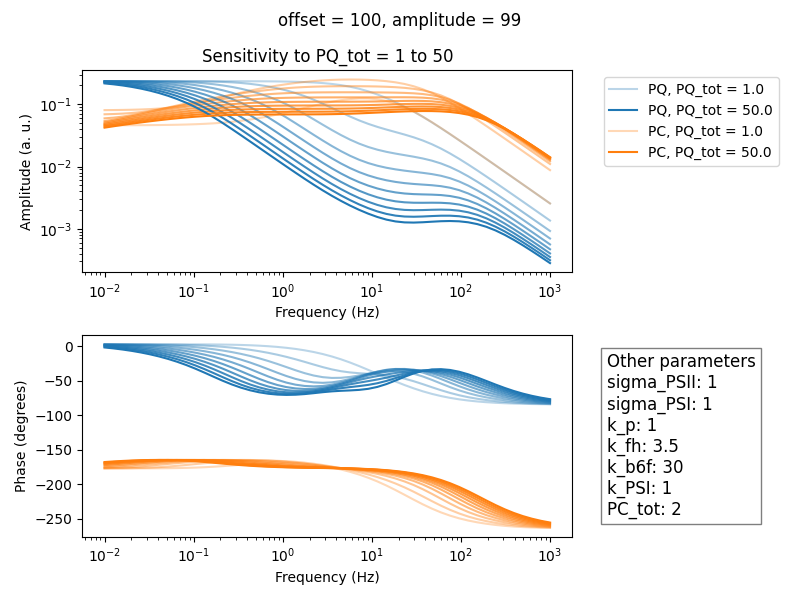

In [90]:
# Plot the results
fig, ax = plt.subplots(2, 1, figsize=(8, 6))
fig.suptitle(f"offset = {offset}, amplitude = {amplitude}")
ax[0].set_title(f"Sensitivity to {parameter_to_vary} = {min_value} to {max_value}")
alpha_values = np.linspace(0.3, 1, n_values)
for i, value in enumerate(parameter_values):
    ax[0].loglog(frequencies, harmonics_PQ_values[i]['A_0'], color = "C0", alpha = alpha_values[i])
    ax[0].loglog(frequencies, harmonics_PC_values[i]['A_0'], color = "C1", alpha = alpha_values[i])
    ax[1].semilogx(frequencies, harmonics_PQ_values[i]['P_0'] + 90, color = "C0", alpha = alpha_values[i])
    ax[1].semilogx(frequencies, harmonics_PC_values[i]['P_0'] + 90 - 360, color = "C1", alpha = alpha_values[i])

ax[0].plot([], [], color = "C0", alpha = alpha_values[0], label = f"PQ, {parameter_to_vary} = {parameter_values[0]}")
ax[0].plot([], [], color = "C0", alpha = alpha_values[-1], label = f"PQ, {parameter_to_vary} = {parameter_values[-1]}")
ax[0].plot([], [], color = "C1", alpha = alpha_values[0], label = f"PC, {parameter_to_vary} = {parameter_values[0]}")
ax[0].plot([], [], color = "C1", alpha = alpha_values[-1], label = f"PC, {parameter_to_vary} = {parameter_values[-1]}")

ax[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

ax[0].set_ylabel('Amplitude (a. u.)')
ax[0].set_xlabel('Frequency (Hz)')
ax[1].set_xlabel('Frequency (Hz)')
ax[1].set_ylabel('Phase (degrees)')

# Create a string with parameter names and values
parameters_str = 'Other parameters'
for key in parameters.keys():
    if key == parameter_to_vary:
        continue
    parameters_str += f'\n{key}: {parameters[key]}'
    
ax[1].text(1.07, 0.5, parameters_str, fontsize=12, verticalalignment='center', transform=ax[1].transAxes, bbox=dict(facecolor='white', alpha=0.5))

fig.tight_layout()

fig.savefig(fig_folder + f"sensitivity_bode_{parameter_to_vary}_offset_{offset}_amp_{amplitude}_{min_value}_{max_value}_test.png", dpi=300)

In [95]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact
from IPython.display import display
import matplotlib.gridspec as gridspec

# Assuming parameter_values, frequencies, times, X_PQ_red_values, X_PC_red_values are defined elsewhere

# Create sliders for parameter and frequency
param_slider = widgets.SelectionSlider(
    options=parameter_values,
    value=parameter_values[0],
    description=f'{parameter_to_vary}:',
    continuous_update=False
)

freq_slider = widgets.SelectionSlider(
    options=frequencies,
    value=frequencies[0],
    description='Frequency:',
    continuous_update=False
)

parameters_str = 'Other parameters'
for key in parameters.keys():
    if key == parameter_to_vary:
        continue
    parameters_str += f'\n{key}: {parameters[key]}'

# Define the update function
def update_plot(param, frequency):
    i_param = np.where(parameter_values == param)[0][0]
    i_freq = np.where(frequencies == frequency)[0][0]
    
    thin = 1
    thick = 3
    
    fig = plt.figure(figsize=(12, 6))
    gs = gridspec.GridSpec(2, 2)
    ax = fig.add_subplot(gs[:, 0])
    ax.plot(times[i_freq], X_PQ_red_values[i_param][i_freq], label='PQ')
    ax.plot(times[i_freq], X_PC_red_values[i_param][i_freq], label='PC')
    ax.set_title(f'{parameter_to_vary}: {parameter_values[i_param]:.2f}, Frequency: {frequencies[i_freq]:.2f} Hz')
    ax.set_xlabel('Time (a. u.)')
    ax.set_ylabel('Degree of reduction (C_red/C_tot)')
    ax.legend()
    ax.set_ylim(0, 1)
    
    ax2 = fig.add_subplot(gs[0, 1])
    ax3 = fig.add_subplot(gs[1, 1])
    for i, value in enumerate(parameter_values):
        ax2.loglog(frequencies, harmonics_PQ_values[i]['A_0'], color = "C0", alpha = alpha_values[i], linewidth = thin)
        ax2.loglog(frequencies, harmonics_PC_values[i]['A_0'], color = "C1", alpha = alpha_values[i], linewidth = thin)
        ax2.axvline(frequencies[i_freq], color='gray', linestyle='--')
        ax3.semilogx(frequencies, harmonics_PQ_values[i]['P_0'] + 90, color = "C0", alpha = alpha_values[i], linewidth = thin)
        ax3.semilogx(frequencies, harmonics_PC_values[i]['P_0'] + 90 - 360, color = "C1", alpha = alpha_values[i], linewidth = thin)
        ax3.axvline(frequencies[i_freq], color='gray', linestyle='--')
    
    ax2.loglog(frequencies, harmonics_PQ_values[i_param]['A_0'], color = "C0", linewidth=thick)
    ax2.loglog(frequencies, harmonics_PC_values[i_param]['A_0'], color = "C1", linewidth=thick)
    ax3.semilogx(frequencies, harmonics_PQ_values[i_param]['P_0'] + 90, color = "C0", linewidth=thick)
    ax3.semilogx(frequencies, harmonics_PC_values[i_param]['P_0'] + 90 - 360, color = "C1", linewidth=thick)
    
    ax2.set_title(f"Sensitivity to {parameter_to_vary}")
    ax2.set_ylabel('Amplitude (a. u.)')
    ax2.set_xlabel('Frequency (Hz)')
    ax3.set_xlabel('Frequency (Hz)')
    ax3.set_ylabel('Phase (degrees)') 
    
    ax3.text(1.07, 0.5, parameters_str, fontsize=12, verticalalignment='center', transform=ax3.transAxes, bbox=dict(facecolor='white', alpha=0.5))

    
    plt.tight_layout()
    plt.show()

# Use interact to link the sliders to the update function
interact(update_plot, param=param_slider, frequency=freq_slider)

interactive(children=(SelectionSlider(continuous_update=False, description='PQ_tot:', options=(1.0, 6.44444444…

<function __main__.update_plot(param, frequency)>

C:\Users\Orlando\AppData\Local\Temp\ipykernel_37684\1362696141.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


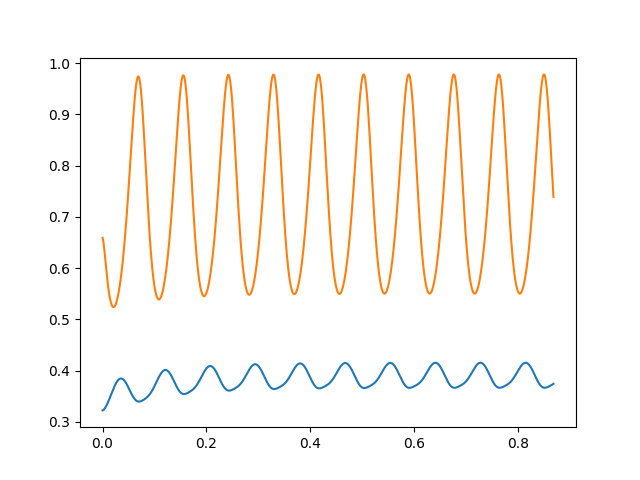

In [40]:
##### plot specific frequency ####

param = 10
i_param = tools.closest_index(parameter_values, param)

frequency = 12
i_freq = tools.closest_index(frequencies, frequency)

fig, ax = plt.subplots()
ax.plot(times[i_freq], X_PQ_red_values[i_param][i_freq], label='PQ')
ax.plot(times[i_freq], X_PC_red_values[i_param][i_freq], label='PC')


